# Stock Returns Using different Predicitive Models in Machine Learning

#### This notebook is a follow up of my script files. 
#### The script is divided into different classes to avoid misunderstanding my approach.
##### Begining with the first class
---------------------------------------------------------------------------------------------
###### FetchData: Fetches the stock data using YAHOO API provided by pandas
---------------------------------------------------------------------------------------------
###### Predictors: Extract the predictors from the TECHNICAL INDICATOR CLASS
###### Note that you can add as many predictors as desired. Avoid using excess
###### predictors because some are highly correlated and would only reduce the test accuracy.
---------------------------------------------------------------------------------------------
#### NormalizeData: this is a neccesary step to avoid giving importance to one feature vector
#### over the other. Data normalization is a common use case in predictive modeling.
#### the goal is required for the algorithms to model the data correctly.
-----------------------------------------------------------------------------------------
#### feature_importance: To be able to understand the feature vectors that make the most impact on our data
#### feature importance plot is necessary. However i have not applied the result of the importance here.
#### A common used case here would be to sellect only the feature >0.8 as our final predictors.

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  5 00:44:16 2018

@author: kennedy
"""

import pandas as pd
import numpy as np
import pandas_datareader.data as web
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from TechnicalIndicators import TechnicalIndicators
from datetime import datetime



class FetchData(object):
    
    def __init__(self, data, source, start, end):
        '''
        Arguments:
            @data: takes in the name of the stock
                    for analysis
            @source: API from where data is fetched from
                    mostly yahoo.
            @start: Start date for data source in the format
                    e.g 
                    >>datetime(2000, 1, 1)
            @end: the end of the timeseries for data collection
                    e.g 
                    >>datetime.now()
            @train: This is boolean for checking train or 
                    test score.
    
        Use Case:
            start_date = datetime(2000, 1, 1)
            end_date = datetime.now()
            dataframe = web.DataReader("TSLA", "yahoo", start_date, end_date)
            dataframe = fetchData("TSLA", "yahoo", start_date, end_date).fetch()
        '''
        self.data = data
        self.source = source
        self.start = start
        self.end = end
        self.train = False
        
    def fetch(self):
        if not self.data:
            raise ValueError('Stock name not available')
        elif not self.start or not self.end:
            raise ValueError('Start date and End date not specified')
        else:
            dataframe = web.DataReader(self.data, self.source, self.start, self.end)
        return dataframe
       
dataframe = FetchData("TSLA", "yahoo", datetime(2000, 1, 1), datetime.now()).fetch()

class Predictors:
    def __init__(self, data):
        '''
        Contains a list of technical indicators.
        This indicators are what we put together
        For this project we would focus on the  following Indicators
            --Exponential Moving Average --> For predicting Trend
            --Commodity Channel Index --> Forecasting the future price move
            --Momentum --> The rate of change of price especially clossing
            --Stochastic Oscillator --> Future price movement
            --Mass Index -->Average Exponential Index
            --Force -->Relative Strength Index
        '''
        self.dataframe = data
        return self.predictors()
    
    def predictors(self):
        self.dataframe['MA'] = TechnicalIndicators.moving_average(self.dataframe, 10)
        self.dataframe['EMA'] = TechnicalIndicators.exponential_moving_average(self.dataframe, 10)
        self.dataframe['CCI'] = TechnicalIndicators.commodity_channel_index(self.dataframe, 10)
        self.dataframe['MMT'] = TechnicalIndicators.momentum(self.dataframe, 10)
        self.dataframe['SOD'] = TechnicalIndicators.stochastic_oscillator_d(self.dataframe, 10)
        self.dataframe['SOK'] = TechnicalIndicators.stochastic_oscillator_k(self.dataframe)
        self.dataframe['FI'] = TechnicalIndicators.force_index(self.dataframe, 10)
        self.dataframe['MI'] = TechnicalIndicators.mass_index(self.dataframe, 10)
        return self.dataframe.fillna(0, inplace=True)
        
        
#pred = Predictors(dataframe)  

class NormalizeData(object):
    def __init__(self,data, short_price, long_price):
        
        '''
        :short_price: 
                    MA short and Long
        :long_price:
                    MA Long and Short
        '''
        self.short_price = short_price
        self.long_price = long_price
        self.data = data
        
    def normalizeData(self):
        Xf = pd.DataFrame(MinMaxScaler().fit_transform(self.data.drop(['Close'], axis = 1).values))
        Xf.columns = dataframe.columns.drop(['Close'])
        if not self.long_price > self.short_price:
            raise ValueError('Short price should be less than long')
        elif self.short_price == self.long_price:
            raise ValueError('Prices should not be the same')
        else:
            '''
            The Yf states:
                When short_price is greater than Long_price--> Buy
                When short_price is less than long_price --> Sell
            '''
           Yf = np.where(self.data['Close'].rolling(window = self.short_price).mean() > self.data['Close'].rolling(window = self.long_price).mean(),1,0)
        #Train/Test Split
        X_train, X_test, Y_train, Y_test = train_test_split(Xf, Yf, test_size = 0.3, random_state = False)
        return Xf, Yf, X_train, X_test, Y_train, Y_test
        


class feature_importance(object):
    def __init__(self, Xf, Yf):
        import matplotlib.pyplot as plt
        import seaborn as sns
        from sklearn.ensemble import RandomForestClassifier
        self.model = RandomForestClassifier(n_estimators=250, max_depth=25)
        self.model.fit(Xf, Yf)
        importance = pd.DataFrame({'features': Xf.columns,
                        'importances': self.model.feature_importances_})
        importance = importance.sort_values('importances', ascending=False)
        plt.figure(figsize = (16,12))
        sns.barplot(importance.importances, importance.features)
        plt.title('Feature Importance Plot')
        plt.show()
        
#feature_importance(dataframe, Yf)
#Xf, Yf, X_train, X_test, Y_train, Y_test = NormalizeData(7, 15).normalizeData()

# Predictive Models

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  5 04:33:47 2018

@author: kennedy
"""
import pandas as pd
import numpy as np
import graphviz 
from datetime import datetime
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from TechnicalIndicators import TechnicalIndicators
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_validate
from xgboost.sklearn import XGBClassifier

class Model():
    
    def __init__(self):
        '''
        Define the Classifiers to be Used for 
        @Classifiers:
                    List of Tuples
        @Pipeline: Channel of Estimators
        @Employ the use of GridSearchCV
        Predicting Returns
        '''
        self.N_NEIGBORS = 10
        self.KERNELS = ['linear', 'rbf']
        self.GAMMA = [0.0001, 0.001, 0.01, 1]
        self.CRITERION = ['gini', 'entropy']
        self.MAX_DEPTH = 5
        self.MAX_FEATURES = ['auto', 'sqrt', 'log2']
        self.N_VALIDATION = 2
        self.N_COMPONENTS = 2
        self.BEST_ACCURACY = 0.0
        self.BEST_CLASSIFIER = 0
        self.BEST_GRIDSEARCH = ''
        self.RANGE = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        
        self.pipe_KNN = Pipeline([('normalizer', StandardScaler()), ('clf', KNeighborsClassifier())])
        self.pipe_KNN_PCA = Pipeline([('normalizer', StandardScaler()), ('PCA', PCA(n_components = self.N_COMPONENTS)),
                              ('clf', KNeighborsClassifier())])
        self.pipe_SVC = Pipeline([('normalizer', StandardScaler()), ('clf', SVC())])
        self.pipe_SVC_PCA = Pipeline([('normalizer', StandardScaler()), ('PCA', PCA(n_components = self.N_COMPONENTS)), 
                              ('clf', SVC())])
        self.pipe_GaussianProcessClassifier = Pipeline([('normalizer', StandardScaler()), 
                                                ('clf', GaussianProcessClassifier(1.0 * RBF(1.0)))])
        self.pipe_GaussianProcessClassifier_PCA = Pipeline([('normalizer', StandardScaler()), ('PCA', PCA(n_components = self.N_COMPONENTS)), 
                                                    ('clf', GaussianProcessClassifier(1.0 * RBF(1.0)))])
        self.pipe_LogisticRegression = Pipeline([('normalizer', StandardScaler()), ('clf', LogisticRegression())])
        self.pipe_LogisticRegression_PCA = Pipeline([('normalizer', StandardScaler()),('PCA', PCA(n_components = self.N_COMPONENTS)), 
                                           ('clf', LogisticRegression())])
        self.pipe_DecisionTreeClassifier = Pipeline([('normalizer', StandardScaler()), ('clf', DecisionTreeClassifier())])
        self.pipe_DecisionTreeClassifier_PCA = Pipeline([('normalizer', StandardScaler()), ('PCA', PCA(n_components = self.N_COMPONENTS)), 
                                                 ('clf', DecisionTreeClassifier())])
        self.pipe_RandomForestClassifier = Pipeline([('normalizer', StandardScaler()), ('clf', RandomForestClassifier())])
        self.pipe_RandomForestClassifier_PCA = Pipeline([('normalizer', StandardScaler()), ('PCA', PCA(n_components = self.N_COMPONENTS)), 
                                                 ('clf', RandomForestClassifier())])
        self.pipe_AdaBoostClassifier = Pipeline([('normalizer', StandardScaler()), 
                                         ('clf', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))])
        self.pipe_AdaBoostClassifier_PCA = Pipeline([('normalizer', StandardScaler()), ('PCA', PCA(n_components = self.N_COMPONENTS)), 
                                             ('clf', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))])
        self.pipe_GaussianNB = Pipeline([('normalizer', StandardScaler()), ('clf', GaussianNB())])
        self.pipe_GaussianNB_PCA = Pipeline([('normalizer', StandardScaler()), ('PCA', PCA(n_components = self.N_COMPONENTS)), 
                                     ('clf', GaussianNB())])
        self.pipe_QuadraticDiscriminantAnalysis = Pipeline([('normalizer', StandardScaler()), 
                                                    ('clf', QuadraticDiscriminantAnalysis())])
        self.pipe_GradientBoostingClassifier = Pipeline([('normalizer', StandardScaler()), 
                                                    ('clf', GradientBoostingClassifier())])
        self.pipe_XGBClassifier = Pipeline([('normalizer', StandardScaler()), 
                                            ('clf', XGBClassifier())])
        self.pipe_QuadraticDiscriminantAnalysis_PCA = Pipeline([('normalizer', StandardScaler()), 
                                                    ('PCA', PCA(n_components = self.N_COMPONENTS)), ('clf', QuadraticDiscriminantAnalysis())])
        
        self.pipe_KNN_param = [{'clf__n_neighbors': self.RANGE}]
        
        self.pipe_SVC_params = [{'clf__kernel': self.KERNELS,
                                'clf__C': self.RANGE,
                                'clf__gamma': self.GAMMA}]
        
        self.pipe_AdaBoostClassifier_param = [{'clf__n_estimators': [200],
                                               'clf__learning_rate': [0.01]}]
        
        self.pipe_GradientBoostingClassifier_params = [{'clf__n_estimators': [200],
                                                        'clf__learning_rate': [0.01]}]
        self.XGBClassifier_params = [{'clf__n_estimators': [200],
                                      'clf__learning_rate': [0.01]}]
        self.pipe_RandomForestClassifier_params = [{'clf__criterion': self.CRITERION,
                                                     'clf__max_depth': np.arange(2,10),
                                                     'clf__min_samples_split': np.arange(2,10),
                                                     'clf__min_samples_leaf': np.arange(2,10),
                                                     'clf__max_features': self.MAX_FEATURES,
                                                     'clf__n_estimators': np.arange(1,2)}]
        self.pipe_DecisionTreeClassifier_param = [{'clf__max_depth': np.arange(2,10),
                                                    }]
        self.pipe_GaussianNB_params = [{'clf__priors': [None]}]
        
        self.pipe_GaussianProcessClassifier_params = [{'clf__kernel': [1**2 * RBF(1.0)]}]
    
        self.pipe_LogisticRegression_params = [{'clf__penalty': ['l1', 'l2'],
                                        		'clf__C': [1.0, 0.5, 0.1], 'clf__solver': ['liblinear']}]
    
        self.QuadraticDiscriminantAnalysis_params = [{'clf__priors': [None]}]
        
        
        
    def optimize(self, X_train, X_test, Y_train, Y_test):
        '''
        Here we call the GridSearchCV class to get
        the best parameters or better still optimized parameters
        for our data.
        Remember the Gridsearch is done througk the pipeline.
        '''
        
        self.grid_RandomForestClassifier = GridSearchCV(estimator = self.pipe_RandomForestClassifier, 
                                                        param_grid = self.pipe_RandomForestClassifier_params,
                                                        scoring='accuracy',	cv = self.N_VALIDATION)
        self.grid_GradientBoostingClassifier = GridSearchCV(estimator = self.pipe_GradientBoostingClassifier, 
                                                        param_grid = self.pipe_GradientBoostingClassifier_params,
                                                        scoring='accuracy',	cv = self.N_VALIDATION)
        self.grid_XGBClassifier = GridSearchCV(estimator = self.pipe_XGBClassifier, 
                                                        param_grid = self.XGBClassifier_params,
                                                        scoring='accuracy',	cv = self.N_VALIDATION)
        self.grid_RandomForestClassifier_PCA = GridSearchCV(estimator = self.pipe_RandomForestClassifier_PCA, 
                                                            param_grid = self.pipe_RandomForestClassifier_params,
                                                            scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_KNN = GridSearchCV(estimator = self.pipe_KNN, param_grid = self.pipe_KNN_param,
                                     scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_KNN_PCA = GridSearchCV(estimator = self.pipe_KNN_PCA, param_grid = self.pipe_KNN_param,
                             scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_SVC = GridSearchCV(estimator = self.pipe_SVC, param_grid = self.pipe_SVC_params,
                                             scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_SVC_PCA = GridSearchCV(estimator = self.pipe_SVC_PCA, param_grid = self.pipe_SVC_params,
                                     scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_GaussianProcessClassifier = GridSearchCV(estimator = self.pipe_GaussianProcessClassifier, 
                                                           param_grid = self.pipe_GaussianProcessClassifier_params,
                                                           scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_GaussianProcessClassifier_PCA = GridSearchCV(estimator = self.pipe_GaussianProcessClassifier_PCA, 
                                                   param_grid = self.pipe_GaussianProcessClassifier_params,
                                                   scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_LogisticRegression = GridSearchCV(estimator = self.pipe_LogisticRegression, 
                                                    param_grid = self.pipe_LogisticRegression_params,
                                                    scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_LogisticRegression_PCA = GridSearchCV(estimator = self.pipe_LogisticRegression_PCA, 
                                                    param_grid = self.pipe_LogisticRegression_params,
                                                    scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_DecisionTreeClassifier = GridSearchCV(estimator = self.pipe_DecisionTreeClassifier,
                                                        param_grid = self.pipe_DecisionTreeClassifier_param,
                                                        scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_DecisionTreeClassifier_PCA = GridSearchCV(estimator = self.pipe_DecisionTreeClassifier_PCA,
                                                        param_grid = self.pipe_DecisionTreeClassifier_param,
                                                        scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_AdaBoostClassifier = GridSearchCV(estimator = self.pipe_AdaBoostClassifier, 
                                                    param_grid = self.pipe_AdaBoostClassifier_param,
                                                    scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_AdaBoostClassifier_PCA = GridSearchCV(estimator = self.pipe_AdaBoostClassifier_PCA, 
                                                    param_grid = self.pipe_AdaBoostClassifier_param,
                                                    scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_GaussianNB = GridSearchCV(estimator = self.pipe_GaussianNB, param_grid = self.pipe_GaussianNB_params,
                                            scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_GaussianNB_PCA = GridSearchCV(estimator = self.pipe_GaussianNB_PCA, param_grid = self.pipe_GaussianNB_params,
                                            scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_QuadraticDiscriminantAnalysis = GridSearchCV(estimator = self.pipe_QuadraticDiscriminantAnalysis, 
                                                               param_grid = self.QuadraticDiscriminantAnalysis_params,
                                                               scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_QuadraticDiscriminantAnalysis_PCA = GridSearchCV(estimator = self.pipe_QuadraticDiscriminantAnalysis_PCA, 
                                                               param_grid = self.QuadraticDiscriminantAnalysis_params,
                                                               scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.All_grids = {'grid_RandomForestClassifier': self.grid_RandomForestClassifier,
                          'grid_GradientBoostingClassifier': self.grid_GradientBoostingClassifier,
                          'grid_XGBClassifier': self.grid_XGBClassifier,
                          'grid_RandomForestClassifier_PCA': self.grid_RandomForestClassifier_PCA,
                          'grid_KNN': self.grid_KNN, 'grid_KNN_PCA_': self.grid_KNN_PCA,
                          'grid_SVC': self.grid_SVC, 'grid_SVC_PCA': self.grid_SVC_PCA,
                          'grid_GaussianProcessClassifier': self.grid_GaussianProcessClassifier,
                          'grid_GaussianProcessClassifier_PCA': self.grid_GaussianProcessClassifier_PCA,
                          'grid_LogisticRegression': self.grid_LogisticRegression,
                          'grid_LogisticRegression_PCA': self.grid_LogisticRegression_PCA,
                          'grid_DecisionTreeClassifier': self.grid_DecisionTreeClassifier,
                          'grid_DecisionTreeClassifier_PCA': self.grid_DecisionTreeClassifier_PCA,
                          'grid_AdaBoostClassifier': self.grid_AdaBoostClassifier,
                          'grid_AdaBoostClassifier_PCA': self.grid_AdaBoostClassifier_PCA,
                          'grid_GaussianNB': self.grid_GaussianNB, 
                          'grid_GaussianNB_PCA': self.grid_GaussianNB_PCA,
                          'grid_QuadraticDiscriminantAnalysis': self.grid_QuadraticDiscriminantAnalysis,
                          'grid_QuadraticDiscriminantAnalysis_PCA': self.grid_QuadraticDiscriminantAnalysis_PCA}
        
        print('--------------------------------------------------------')
        print('\tPerforming optimization...')
        for classifier_grid_name, classifier_grid in self.All_grids.items():
            print('--------------------------------------------------------')
            print('Classifier: {}'.format(classifier_grid_name))	
        	# Fit grid search	
            classifier_grid.fit(X_train, Y_train)
        	# Best params
            print('Best params: {}'.format(classifier_grid.best_params_))
        	# Best training data accuracy
            print('Best training accuracy: {}'.format(classifier_grid.best_score_))
        	# Predict on test data with best params
            Y_Prediction = classifier_grid.predict(X_test)
        	# Test data accuracy of model with best params
            print('Test set accuracy score for best params: {}'.format(accuracy_score(Y_test, Y_Prediction)))
            print('--------------------------------------------------------')
        	# Track best (highest test accuracy) model
            if accuracy_score(Y_test, Y_Prediction) > self.BEST_ACCURACY:
                self.BEST_ACCURACY = accuracy_score(Y_test, Y_Prediction)
                self.BEST_GRIDSEARCH = classifier_grid
                self.BEST_CLASSIFIER = classifier_grid_name
        print('\nClassifier with best test set accuracy: {}'.format(self.BEST_CLASSIFIER))
        
        return self.BEST_GRIDSEARCH
            

# Technical Indicators

### An aggregate of technicals indicators which passes for predictors.
### The best predictors are used in the deployment algo for making the 
### required prediction on strategy returns.


In [4]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 28 22:50:43 2018

@author: kennedy
"""

"""
Credit:
        https://www.quantopian.com/posts/technical-analysis-indicators-without-talib-code

Bug Fix by Kennedy: 
                    Works fine for library import.
                    returns only column of the indicator result.
                    Can be used as a predictor for for forecasting
                    stock returns using predictive modeling
                    in Machine Learning.
                    
I configured it to meet my demand for multiple predictive modelling.
    
"""

import pandas as pd
import numpy as np


class TechnicalIndicators:
    
    def moving_average(df, n):
        """Calculate the moving average for the given data.
        
        :param df: pandas.DataFrame
        :param n: window
        :return: pandas.DataFrame
        """
        MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_{}'.format(n))
        
        return MA
    
    
    def exponential_moving_average(df, n):
        """
        
        :param df: pandas.DataFrame
        :param n: window of data to take moving exponent mean
        :return: pandas.DataFrame
        """
        EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
        return EMA
    
    
    def momentum(df, n):
        """
        
        :param df: pandas.DataFrame 
        :param n: data window
        :return: pandas.DataFrame
        """
        M = pd.Series(df['Close'].diff(n), name='Momentum_' + str(n))
        return M
    
    
    def rate_of_change(df, n):
        """
        
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        M = df['Close'].diff(n - 1)
        N = df['Close'].shift(n - 1)
        ROC = pd.Series(M / N, name='ROC_' + str(n))
        return ROC
    
    
    def average_true_range(df, n):
        """
        
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        i = 0
        TR_l = [0]
        while i < df.index[-1]:
            TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
            TR_l.append(TR)
            i = i + 1
        TR_s = pd.Series(TR_l)
        ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean(), name='ATR_' + str(n))
        return ATR
    
    
    def bollinger_bands(df, n):
        """
        
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean())
        MSD = pd.Series(df['Close'].rolling(n, min_periods=n).std())
        b1 = 4 * MSD / MA
        B1 = pd.Series(b1, name='BollingerB_' + str(n))
        b2 = (df['Close'] - MA + 2 * MSD) / (4 * MSD)
        B2 = pd.Series(b2, name='Bollinger%b_' + str(n))
        return pd.concat([B1, B2], axis = 1)
    
    
    def ppsr(df):
        """Calculate Pivot Points, Supports and Resistances for given data
        
        :param df: pandas.DataFrame
        :return: pandas.DataFrame
        """
        PP = pd.Series((df['High'] + df['Low'] + df['Close']) / 3)
        R1 = pd.Series(2 * PP - df['Low'])
        S1 = pd.Series(2 * PP - df['High'])
        R2 = pd.Series(PP + df['High'] - df['Low'])
        S2 = pd.Series(PP - df['High'] + df['Low'])
        R3 = pd.Series(df['High'] + 2 * (PP - df['Low']))
        S3 = pd.Series(df['Low'] - 2 * (df['High'] - PP))
        psr = {'PP': PP, 'R1': R1, 'S1': S1, 'R2': R2, 'S2': S2, 'R3': R3, 'S3': S3}
        PSR = pd.DataFrame(psr)
        return PSR
    
    
    def stochastic_oscillator_k(df):
        """Calculate stochastic oscillator %K for given data.
        
        :param df: pandas.DataFrame
        :return: pandas.DataFrame
        """
        SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
        return SOk
    
    
    def stochastic_oscillator_d(df, n):
        """Calculate stochastic oscillator %D for given data.
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
        SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean(), name='SO%d_' + str(n))
        return SOd
    
    
    def trix(df, n):
        """Calculate TRIX for given data.
        
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        EX1 = df['Close'].ewm(span=n, min_periods=n).mean()
        EX2 = EX1.ewm(span=n, min_periods=n).mean()
        EX3 = EX2.ewm(span=n, min_periods=n).mean()
        i = 0
        ROC_l = [np.nan]
        while i + 1 <= df.index[-1]:
            ROC = (EX3[i + 1] - EX3[i]) / EX3[i]
            ROC_l.append(ROC)
            i = i + 1
        Trix = pd.Series(ROC_l, name='Trix_' + str(n))
        return Trix
    
    
    def average_directional_movement_index(df, n, n_ADX):
        """Calculate the Average Directional Movement Index for given data.
        
        :param df: pandas.DataFrame
        :param n: data window
        :param n_ADX: 
        :return: pandas.DataFrame
        """
        i = 0
        UpI = []
        DoI = []
        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
            DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1
        i = 0
        TR_l = [0]
        while i < df.index[-1]:
            TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
            TR_l.append(TR)
            i = i + 1
        TR_s = pd.Series(TR_l)
        ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
        ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, min_periods=n_ADX).mean(),
                        name='ADX_' + str(n) + '_' + str(n_ADX))
        return ADX
    
    
    def macd(df, n_fast, n_slow):
        """Calculate MACD, MACD Signal and MACD difference
        
        :param df: pandas.DataFrame
        :param n_fast: 
        :param n_slow: 
        :return: pandas.DataFrame
        """
        EMAfast = pd.Series(df['Close'].ewm(span=n_fast, min_periods=n_slow).mean())
        EMAslow = pd.Series(df['Close'].ewm(span=n_slow, min_periods=n_slow).mean())
        MACD = pd.Series(EMAfast - EMAslow, name='MACD_' + str(n_fast) + '_' + str(n_slow))
        MACDsign = pd.Series(MACD.ewm(span=9, min_periods=9).mean(), name='MACDsign_' + str(n_fast) + '_' + str(n_slow))
        MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff_' + str(n_fast) + '_' + str(n_slow))
        return pd.concat([MACD, MACDsign, MACDdiff], axis = 1)
    
    
    def mass_index(df, n):
        """Calculate the Mass Index for given data.
        
        :param df: pandas.DataFrame
        :return: pandas.DataFrame
        """
        Range = df['High'] - df['Low']
        EX1 = Range.ewm(span=9, min_periods=9).mean()
        EX2 = EX1.ewm(span=9, min_periods=9).mean()
        Mass = EX1 / EX2
        MassI = pd.Series(Mass.rolling(n).sum(), name='Mass Index')
        return MassI
    
    
    def vortex_indicator(df, n):
        """Calculate the Vortex Indicator for given data.
        
        Vortex Indicator described here:
            http://www.vortexindicator.com/VFX_VORTEX.PDF
        :param df: pandas.DataFrame
        :param n: 
        :return: pandas.DataFrame
        """
        i = 0
        TR = [0]
        while i < df.index[-1]:
            Range = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
            TR.append(Range)
            i = i + 1
        i = 0
        VM = [0]
        while i < df.index[-1]:
            Range = abs(df.loc[i + 1, 'High'] - df.loc[i, 'Low']) - abs(df.loc[i + 1, 'Low'] - df.loc[i, 'High'])
            VM.append(Range)
            i = i + 1
        VI = pd.Series(pd.Series(VM).rolling(n).sum() / pd.Series(TR).rolling(n).sum(), name='Vortex_' + str(n))
        return VI
    
    
    def kst_oscillator(df, r1, r2, r3, r4, n1, n2, n3, n4):
        """Calculate KST Oscillator for given data.
        
        :param df: pandas.DataFrame
        :param r1: 
        :param r2: 
        :param r3: 
        :param r4: 
        :param n1: 
        :param n2: 
        :param n3: 
        :param n4: 
        :return: pandas.DataFrame
        """
        M = df['Close'].diff(r1 - 1)
        N = df['Close'].shift(r1 - 1)
        ROC1 = M / N
        M = df['Close'].diff(r2 - 1)
        N = df['Close'].shift(r2 - 1)
        ROC2 = M / N
        M = df['Close'].diff(r3 - 1)
        N = df['Close'].shift(r3 - 1)
        ROC3 = M / N
        M = df['Close'].diff(r4 - 1)
        N = df['Close'].shift(r4 - 1)
        ROC4 = M / N
        KST = pd.Series(
            ROC1.rolling(n1).sum() + ROC2.rolling(n2).sum() * 2 + ROC3.rolling(n3).sum() * 3 + ROC4.rolling(n4).sum() * 4,
            name='KST_' + str(r1) + '_' + str(r2) + '_' + str(r3) + '_' + str(r4) + '_' + str(n1) + '_' + str(
                n2) + '_' + str(n3) + '_' + str(n4))
        return KST
    
    
    def relative_strength_index(df, n):
        """Calculate Relative Strength Index(RSI) for given data.
        
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
            DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
        RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
        return RSI
    
    
    def true_strength_index(df, r, s):
        """Calculate True Strength Index (TSI) for given data.
        
        :param df: pandas.DataFrame
        :param r: 
        :param s: 
        :return: pandas.DataFrame
        """
        M = pd.Series(df['Close'].diff(1))
        aM = abs(M)
        EMA1 = pd.Series(M.ewm(span=r, min_periods=r).mean())
        aEMA1 = pd.Series(aM.ewm(span=r, min_periods=r).mean())
        EMA2 = pd.Series(EMA1.ewm(span=s, min_periods=s).mean())
        aEMA2 = pd.Series(aEMA1.ewm(span=s, min_periods=s).mean())
        TSI = pd.Series(EMA2 / aEMA2, name='TSI_' + str(r) + '_' + str(s))
        return TSI
    
    
    def accumulation_distribution(df, n):
        """Calculate Accumulation/Distribution for given data.
        
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']
        M = ad.diff(n - 1)
        N = ad.shift(n - 1)
        ROC = M / N
        AD = pd.Series(ROC, name='Acc/Dist_ROC_' + str(n))
        return AD
    
    
    def chaikin_oscillator(df):
        """Calculate Chaikin Oscillator for given data.
        
        :param df: pandas.DataFrame
        :return: pandas.DataFrame
        """
        ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']
        Chaikin = pd.Series(ad.ewm(span=3, min_periods=3).mean() - ad.ewm(span=10, min_periods=10).mean(), name='Chaikin')
        return Chaikin
    
    
    def money_flow_index(df, n):
        """Calculate Money Flow Index and Ratio for given data.
        
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        PP = (df['High'] + df['Low'] + df['Close']) / 3
        i = 0
        PosMF = [0]
        while i < df.index[-1]:
            if PP[i + 1] > PP[i]:
                PosMF.append(PP[i + 1] * df.loc[i + 1, 'Volume'])
            else:
                PosMF.append(0)
            i = i + 1
        PosMF = pd.Series(PosMF)
        TotMF = PP * df['Volume']
        MFR = pd.Series(PosMF / TotMF)
        MFI = pd.Series(MFR.rolling(n, min_periods=n).mean(), name='MFI_' + str(n))
        return MFI
    
    
    def on_balance_volume(df, n):
        """Calculate On-Balance Volume for given data.
        
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        i = 0
        OBV = [0]
        while i < df.index[-1]:
            if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] > 0:
                OBV.append(df.loc[i + 1, 'Volume'])
            if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] == 0:
                OBV.append(0)
            if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] < 0:
                OBV.append(-df.loc[i + 1, 'Volume'])
            i = i + 1
        OBV = pd.Series(OBV)
        OBV_ma = pd.Series(OBV.rolling(n, min_periods=n).mean(), name='OBV_' + str(n))
        return OBV_ma
    
    
    def force_index(df, n):
        """Calculate Force Index for given data.
        
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        F = pd.Series(df['Close'].diff(n) * df['Volume'].diff(n), name='Force_' + str(n))
        return F
    
    
    def ease_of_movement(df, n):
        """Calculate Ease of Movement for given data.
        
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        EoM = (df['High'].diff(1) + df['Low'].diff(1)) * (df['High'] - df['Low']) / (2 * df['Volume'])
        Eom_ma = pd.Series(EoM.rolling(n, min_periods=n).mean(), name='EoM_' + str(n))
        return Eom_ma
    
    
    def commodity_channel_index(df, n):
        """Calculate Commodity Channel Index for given data.
        
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        PP = (df['High'] + df['Low'] + df['Close']) / 3
        CCI = pd.Series((PP - PP.rolling(n, min_periods=n).mean()) / PP.rolling(n, min_periods=n).std(),
                        name='CCI_' + str(n))
        return CCI
    
    
    def coppock_curve(df, n):
        """Calculate Coppock Curve for given data.
        
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        M = df['Close'].diff(int(n * 11 / 10) - 1)
        N = df['Close'].shift(int(n * 11 / 10) - 1)
        ROC1 = M / N
        M = df['Close'].diff(int(n * 14 / 10) - 1)
        N = df['Close'].shift(int(n * 14 / 10) - 1)
        ROC2 = M / N
        Copp = pd.Series((ROC1 + ROC2).ewm(span=n, min_periods=n).mean(), name='Copp_' + str(n))
        return Copp
    
    
    def keltner_channel(df, n):
        """Calculate Keltner Channel for given data.
        
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        KelChM = pd.Series(((df['High'] + df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                           name='KelChM_' + str(n))
        KelChU = pd.Series(((4 * df['High'] - 2 * df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                           name='KelChU_' + str(n))
        KelChD = pd.Series(((-2 * df['High'] + 4 * df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                           name='KelChD_' + str(n))
        return pd.concat([KelChM, KelChU, KelChD], axis = 1)
    
    
    def ultimate_oscillator(df):
        """Calculate Ultimate Oscillator for given data.
        
        :param df: pandas.DataFrame
        :return: pandas.DataFrame
        """
        i = 0
        TR_l = [0]
        BP_l = [0]
        while i < df.index[-1]:
            TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
            TR_l.append(TR)
            BP = df.loc[i + 1, 'Close'] - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
            BP_l.append(BP)
            i = i + 1
        UltO = pd.Series((4 * pd.Series(BP_l).rolling(7).sum() / pd.Series(TR_l).rolling(7).sum()) + (
                    2 * pd.Series(BP_l).rolling(14).sum() / pd.Series(TR_l).rolling(14).sum()) + (
                                     pd.Series(BP_l).rolling(28).sum() / pd.Series(TR_l).rolling(28).sum()),
                         name='Ultimate_Osc')
        return UltO
    
    
    def donchian_channel(df, n):
        """Calculate donchian channel of given pandas data frame.
        :param df: pandas.DataFrame
        :param n:data window
        :return: pandas.DataFrame
        """
        i = 0
        dc_l = []
        while i < n - 1:
            dc_l.append(0)
            i += 1
    
        i = 0
        while i + n - 1 < df.index[-1]:
            dc = max(df['High'].ix[i:i + n - 1]) - min(df['Low'].ix[i:i + n - 1])
            dc_l.append(dc)
            i += 1
    
        donchian_chan = pd.Series(dc_l, name='Donchian_' + str(n))
        donchian_chan = donchian_chan.shift(n - 1)
        return donchian_chan
    
    
    def standard_deviation(df, n):
        """Calculate Standard Deviation for given data.
        
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        std = pd.Series(df['Close'].rolling(n, min_periods=n).std(), name='STD_' + str(n))
        return std


# Feature Engineering Search and Performance 

## The following cell outputs the best features in descending order. 
#### Performance of the various classifiers.
#### Chooses the best classifier for prediction
#### Output strategy returns together with stock returns.

#### based on this we can select the stock with the best strategy result
#### and trade this stock. since the return would be high compared to other stocks.

### Also note that the performance of the algorithm is based on your strategy. tweaking the strategy
### would give different result at different times and this would impact the accuracy score of the test data.


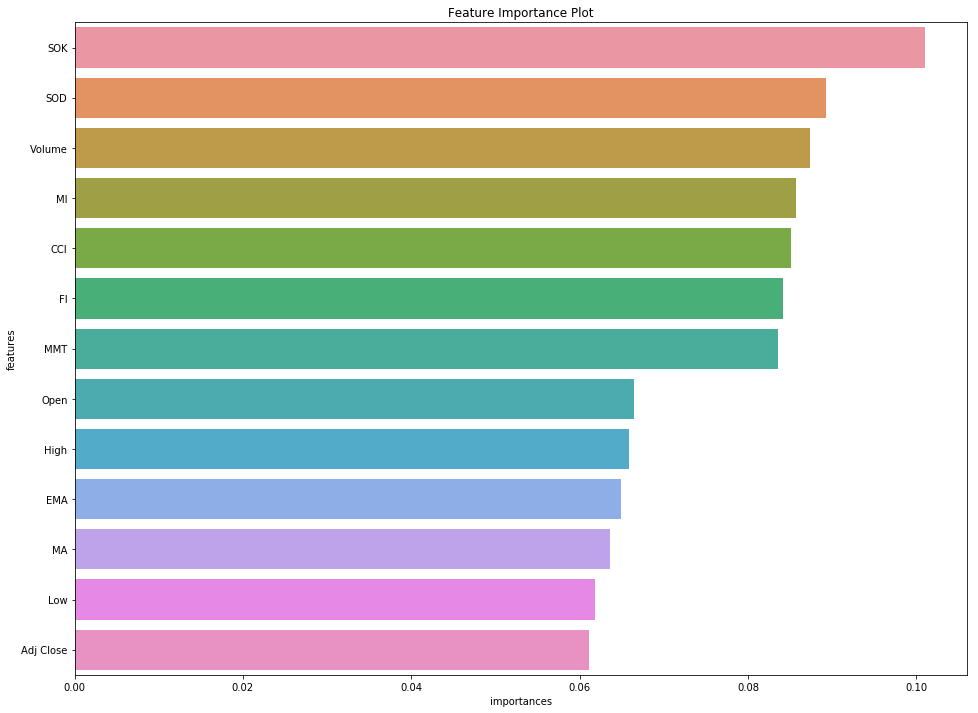

--------------------------------------------------------
	Performing optimization...
--------------------------------------------------------
Classifier: grid_RandomForestClassifier
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__min_samples_leaf': 9, 'clf__min_samples_split': 6}
Best training accuracy: 0.5511049723756906
Test set accuracy score for best params: 0.499194847020934
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_RandomForestClassifier_PCA
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 2, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 3}
Best training accuracy: 0.5428176795580111
Test set accuracy score for best params: 0.4718196457326892
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_KNN
Best params: {'clf__n_neighbors': 3}
Best training accuracy: 0.5103591160220995
T

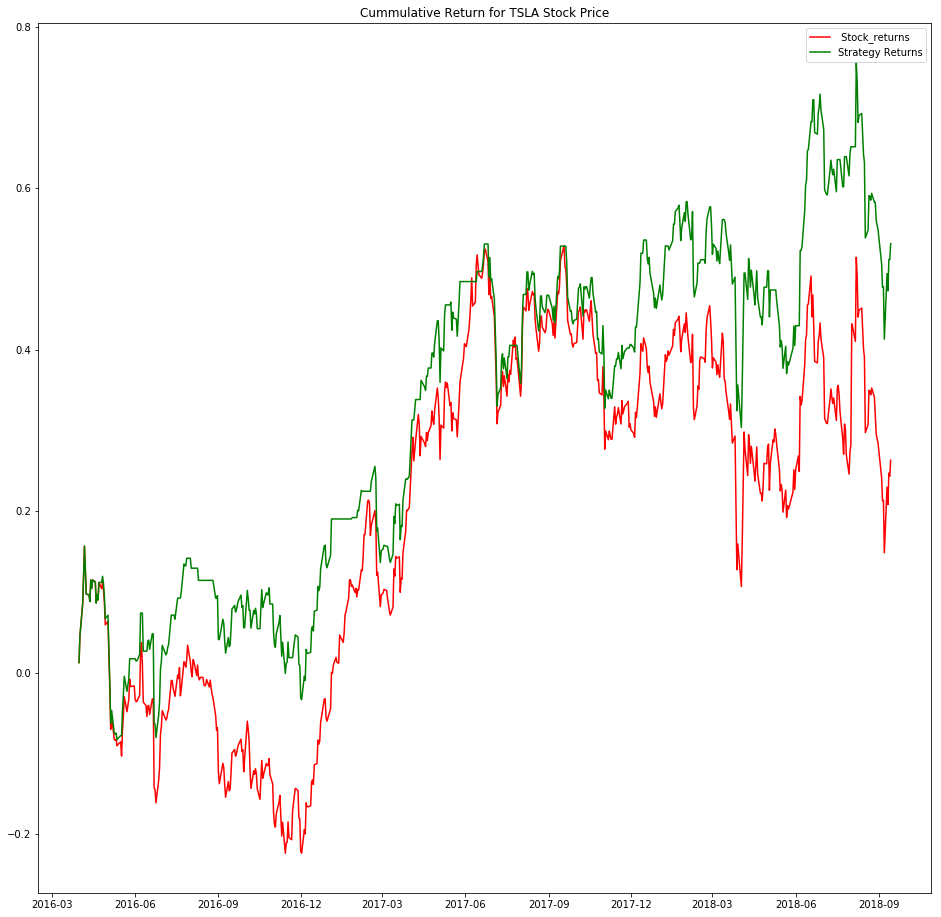

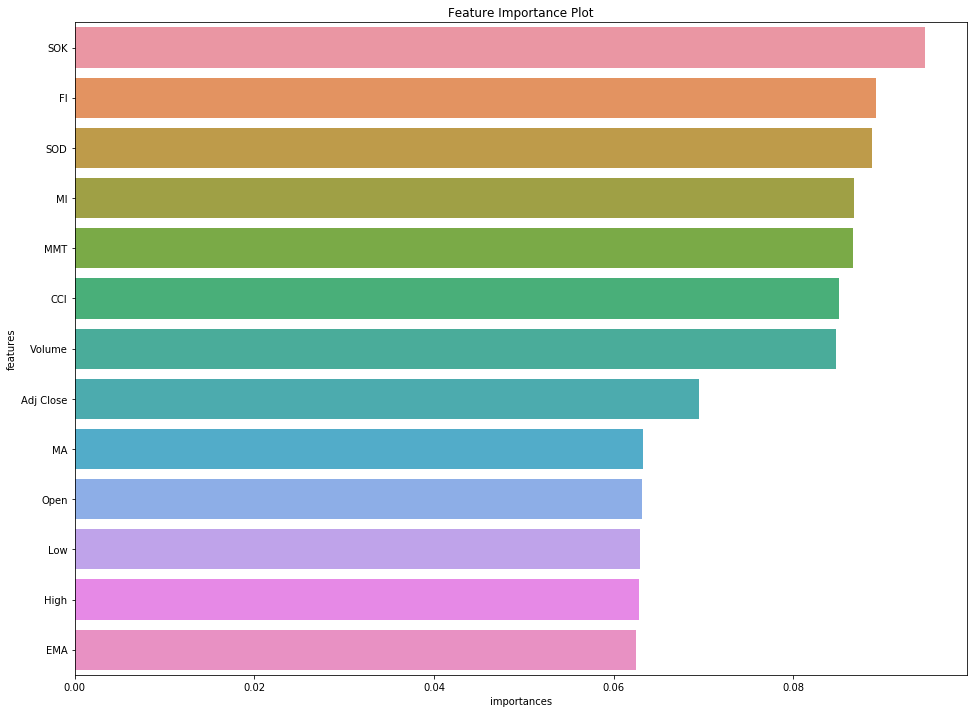

--------------------------------------------------------
	Performing optimization...
--------------------------------------------------------
Classifier: grid_RandomForestClassifier
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 7}
Best training accuracy: 0.5452337583485124
Test set accuracy score for best params: 0.5205382436260623
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_RandomForestClassifier_PCA
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}
Best training accuracy: 0.5336976320582878
Test set accuracy score for best params: 0.5297450424929179
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_KNN
Best params: {'clf__n_neighbors': 9}
Best training accuracy: 0.5239829993928354
Tes

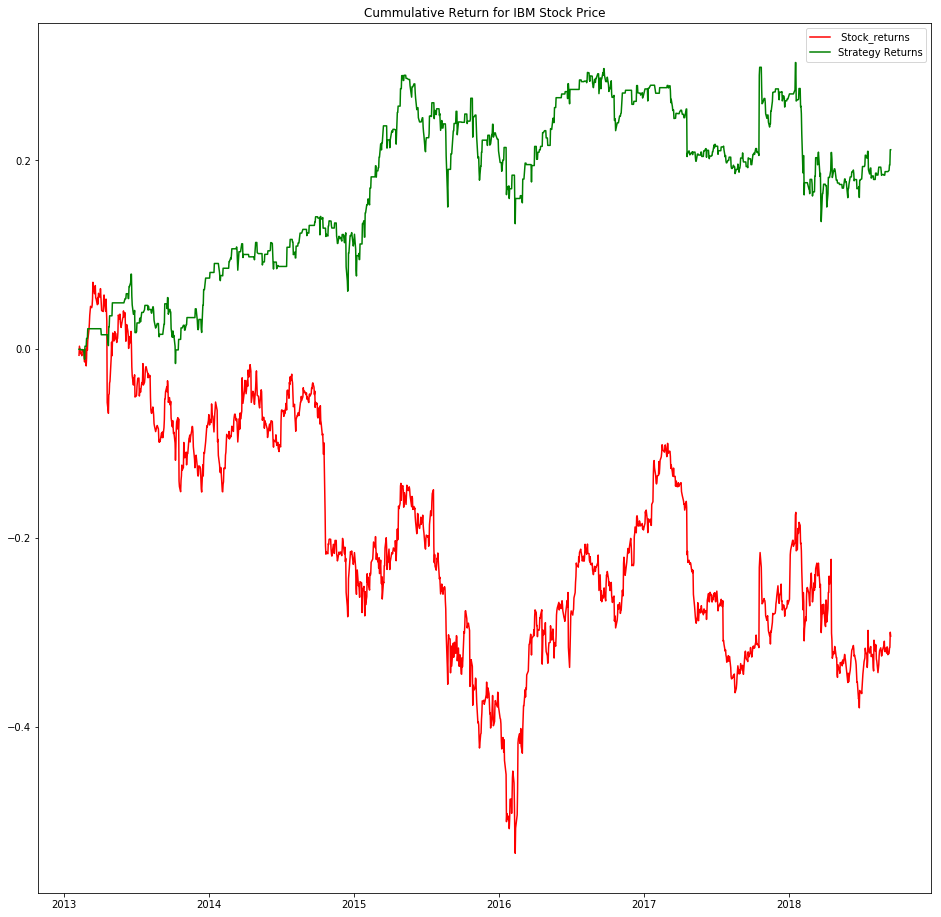

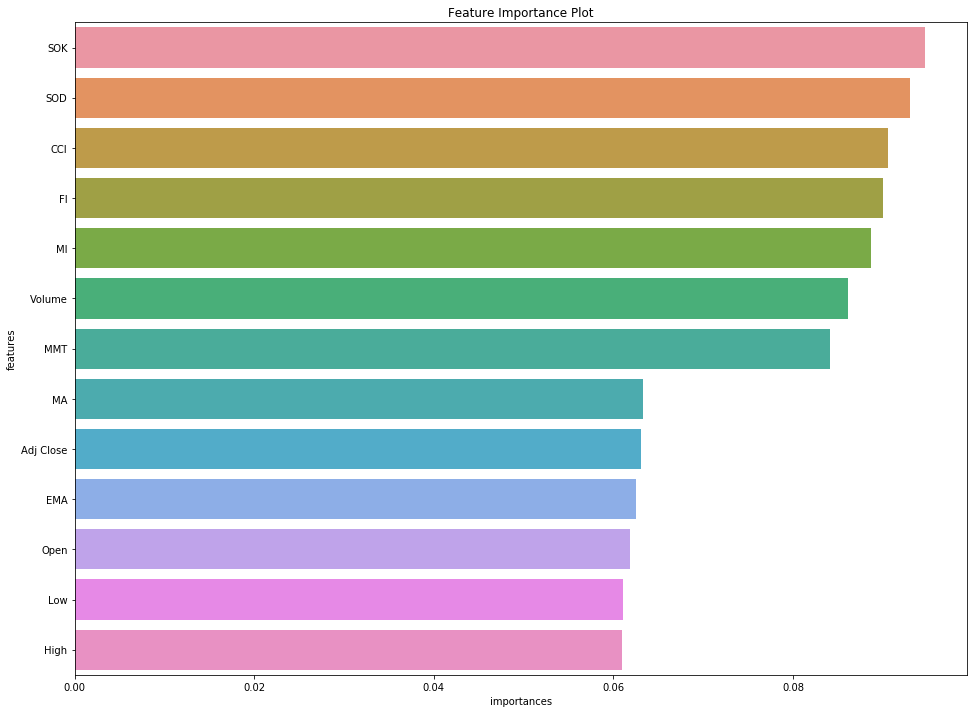

--------------------------------------------------------
	Performing optimization...
--------------------------------------------------------
Classifier: grid_RandomForestClassifier
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 5}
Best training accuracy: 0.5409836065573771
Test set accuracy score for best params: 0.5169971671388102
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_RandomForestClassifier_PCA
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 7}
Best training accuracy: 0.5446265938069217
Test set accuracy score for best params: 0.5155807365439093
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_KNN
Best params: {'clf__n_neighbors': 5}
Best training accuracy: 0.52459016393442

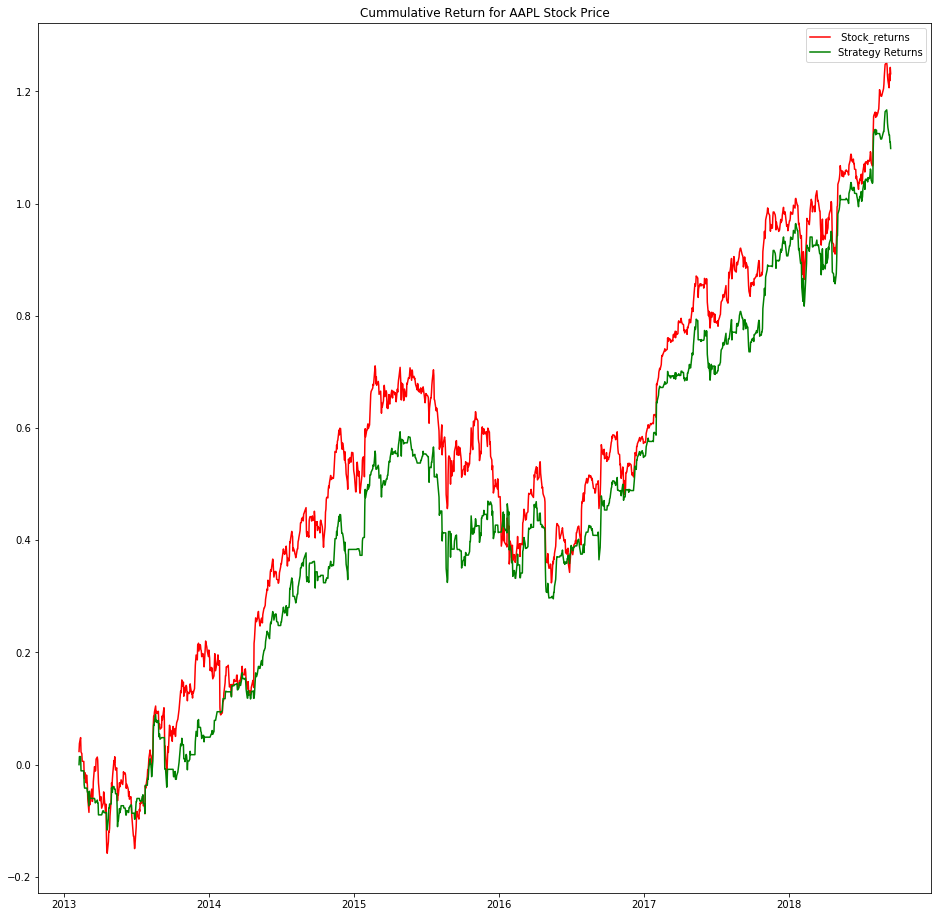

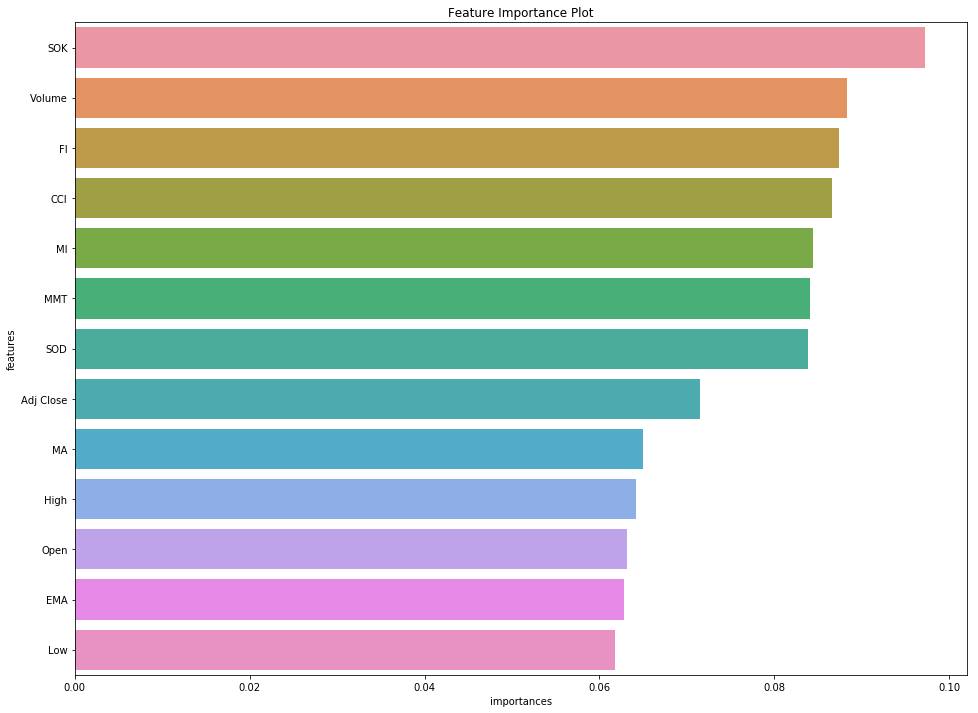

--------------------------------------------------------
	Performing optimization...
--------------------------------------------------------
Classifier: grid_RandomForestClassifier
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 9}
Best training accuracy: 0.546448087431694
Test set accuracy score for best params: 0.5127478753541076
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_RandomForestClassifier_PCA
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 4}
Best training accuracy: 0.5245901639344263
Test set accuracy score for best params: 0.5198300283286119
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_KNN
Best params: {'clf__n_neighbors': 3}
Best training accuracy: 0.5312689738919247
T

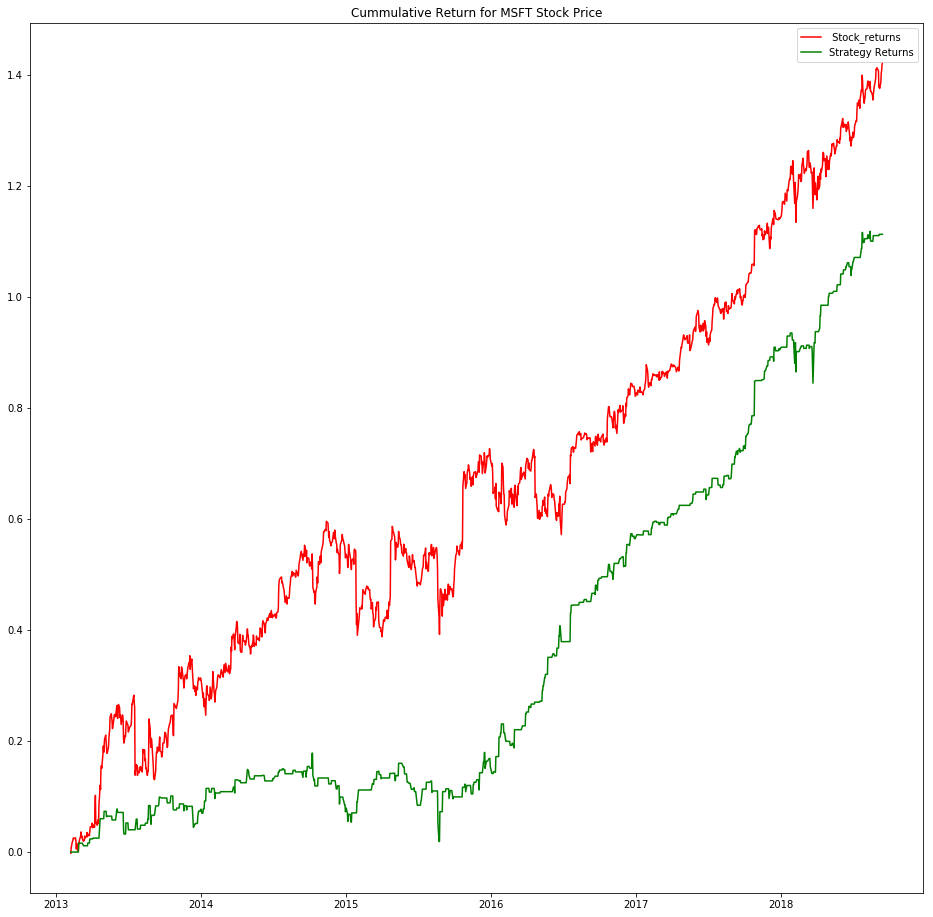

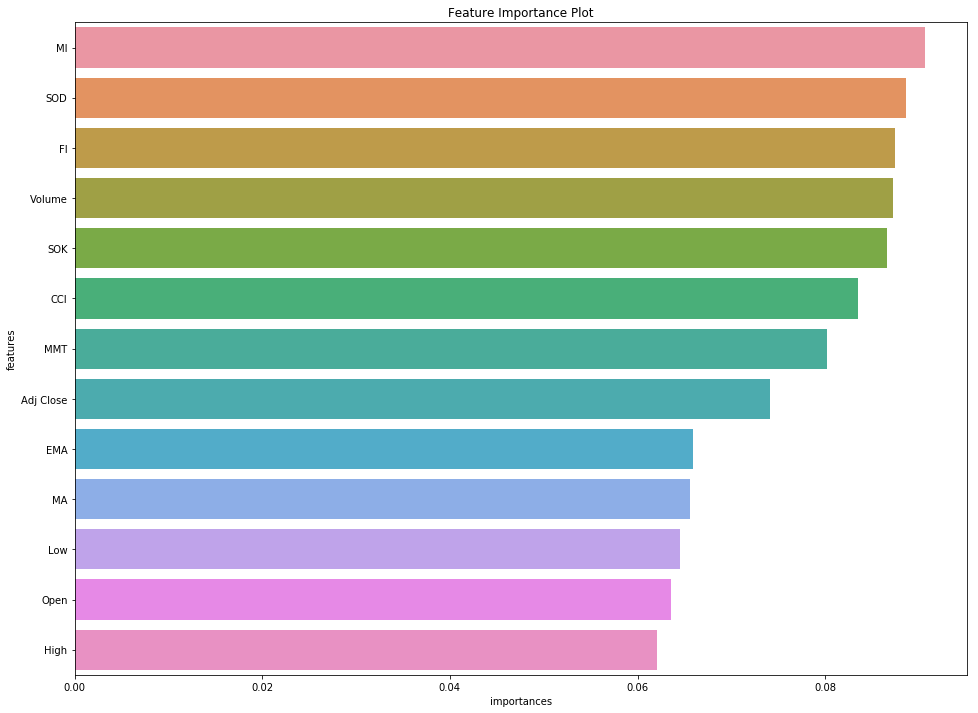

--------------------------------------------------------
	Performing optimization...
--------------------------------------------------------
Classifier: grid_RandomForestClassifier
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2}
Best training accuracy: 0.5297510625379478
Test set accuracy score for best params: 0.5177053824362606
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_RandomForestClassifier_PCA
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 9, 'clf__min_samples_split': 8}
Best training accuracy: 0.5306618093503339
Test set accuracy score for best params: 0.5028328611898017
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_KNN
Best params: {'clf__n_neighbors': 2}
Best training accuracy: 0.51183970856102
Te

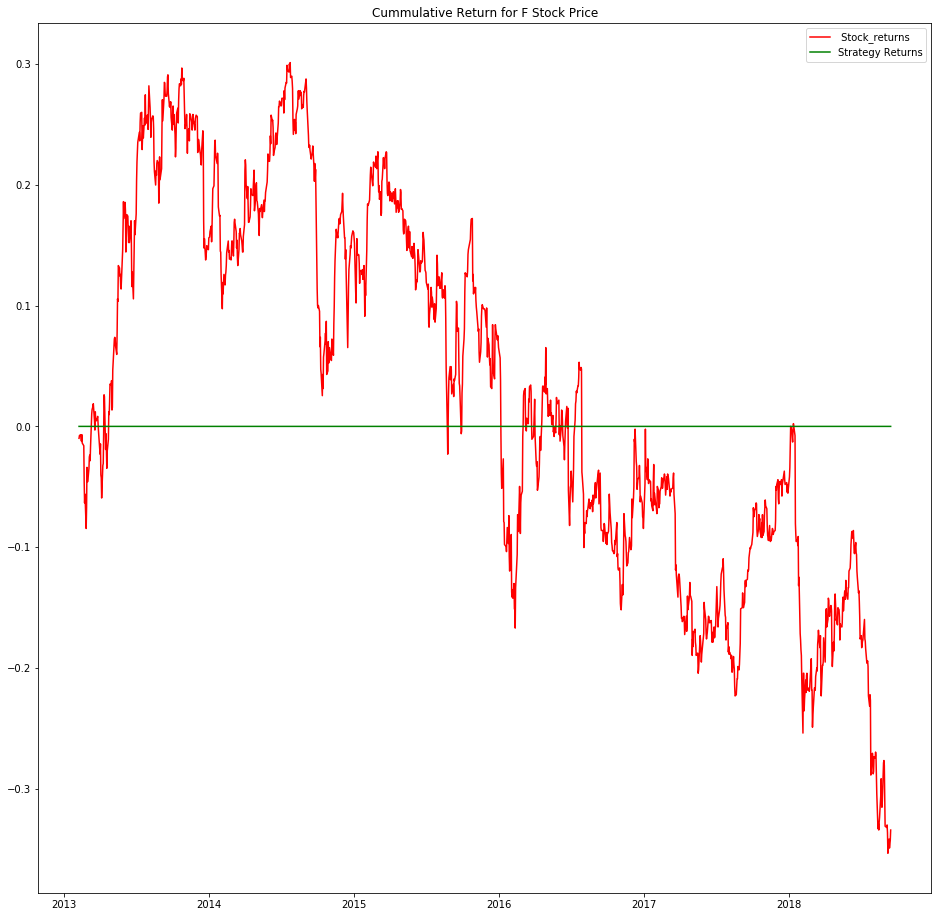

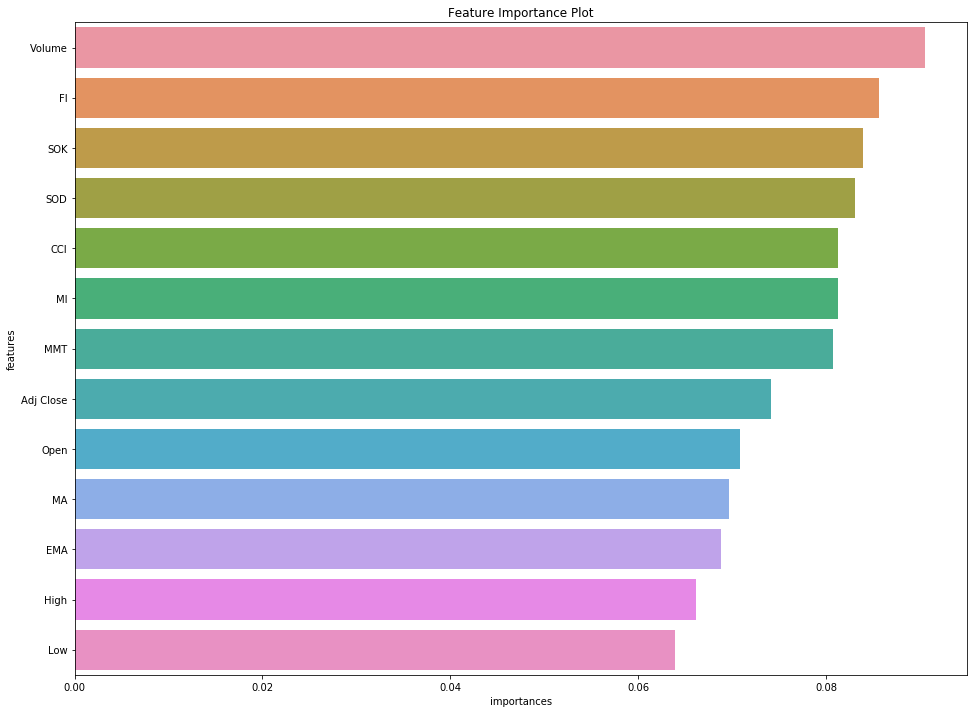

--------------------------------------------------------
	Performing optimization...
--------------------------------------------------------
Classifier: grid_RandomForestClassifier
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 4}
Best training accuracy: 0.5355587808417998
Test set accuracy score for best params: 0.5431472081218274
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_RandomForestClassifier_PCA
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 4}
Best training accuracy: 0.5297532656023222
Test set accuracy score for best params: 0.5076142131979695
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_KNN
Best params: {'clf__n_neighbors': 2}
Best training accuracy: 0.5137880986937591


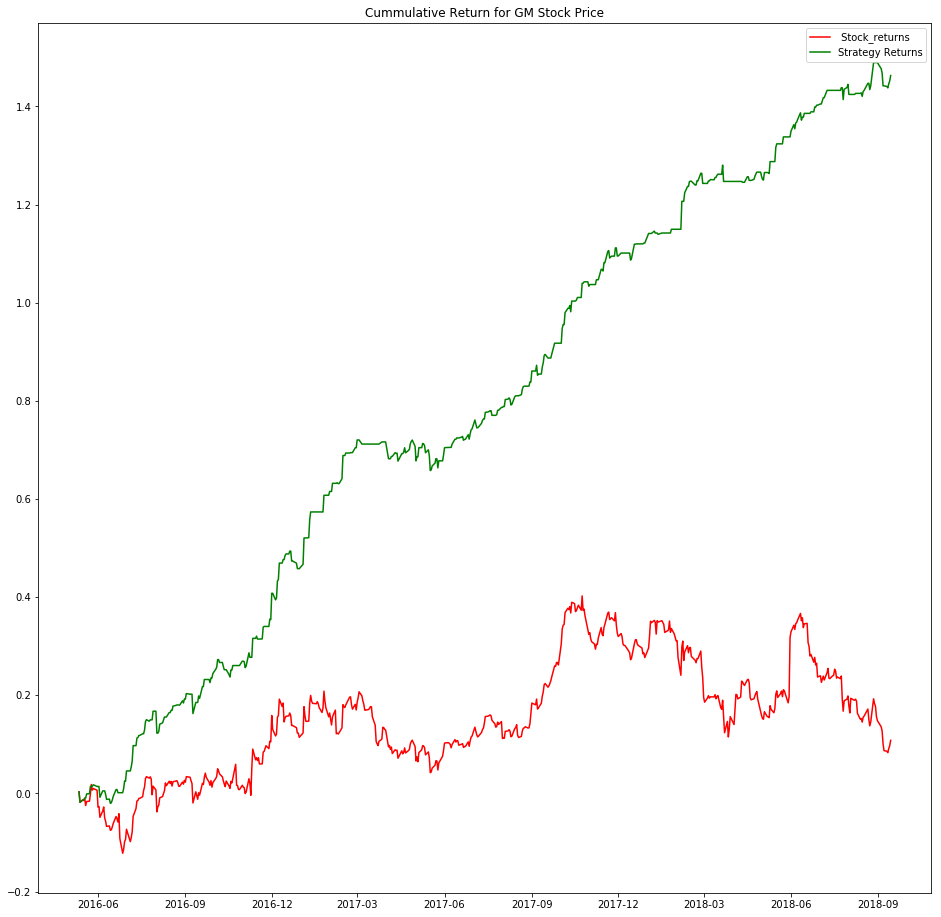

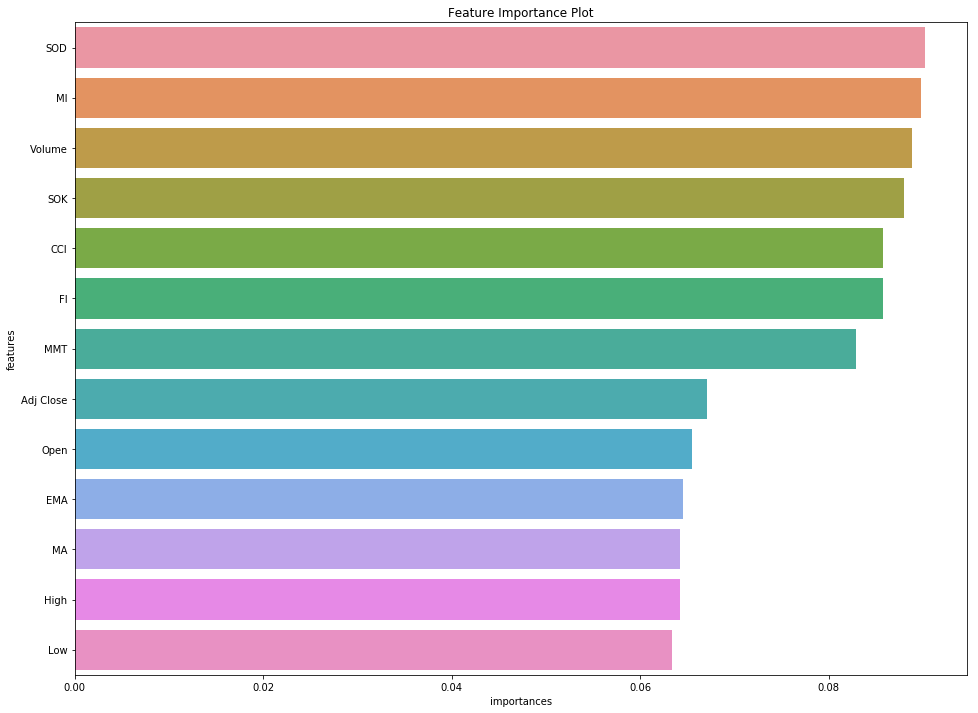

--------------------------------------------------------
	Performing optimization...
--------------------------------------------------------
Classifier: grid_RandomForestClassifier
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 7, 'clf__min_samples_leaf': 9, 'clf__min_samples_split': 3}
Best training accuracy: 0.5272599366865987
Test set accuracy score for best params: 0.4963084495488105
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_RandomForestClassifier_PCA
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 6}
Best training accuracy: 0.5293703833978192
Test set accuracy score for best params: 0.48728465955701394
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_KNN
Best params: {'clf__n_neighbors': 10}
Best training accuracy: 0.513542033063665

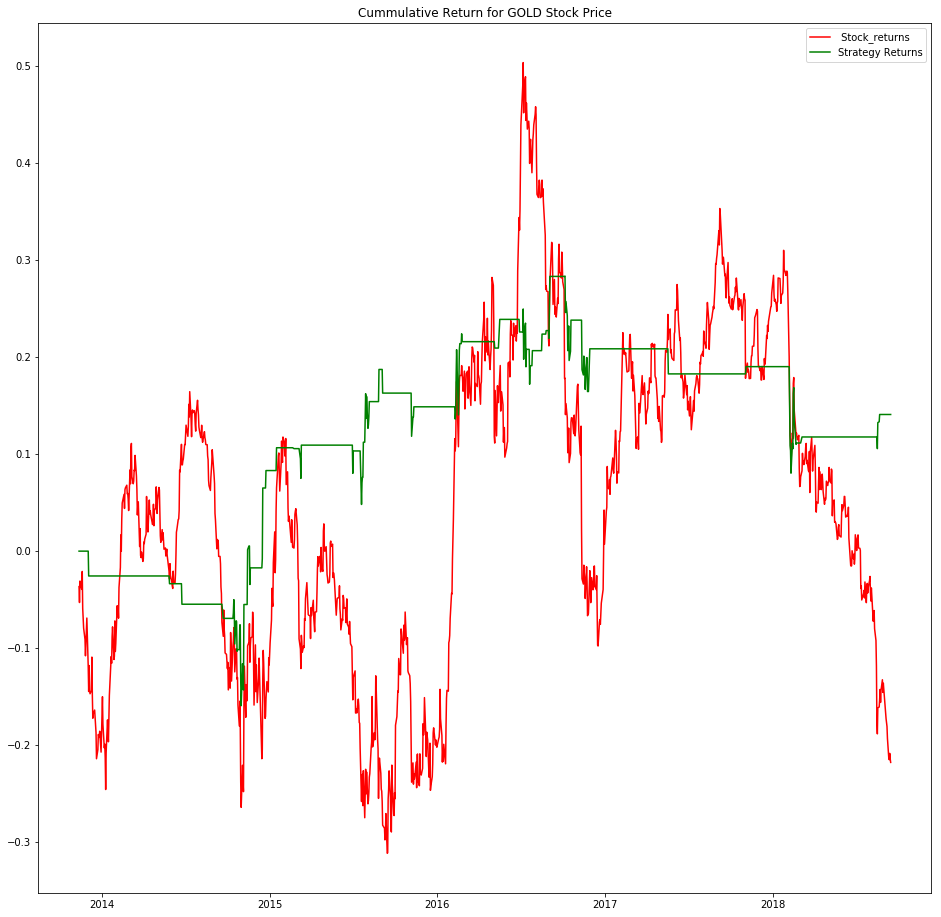

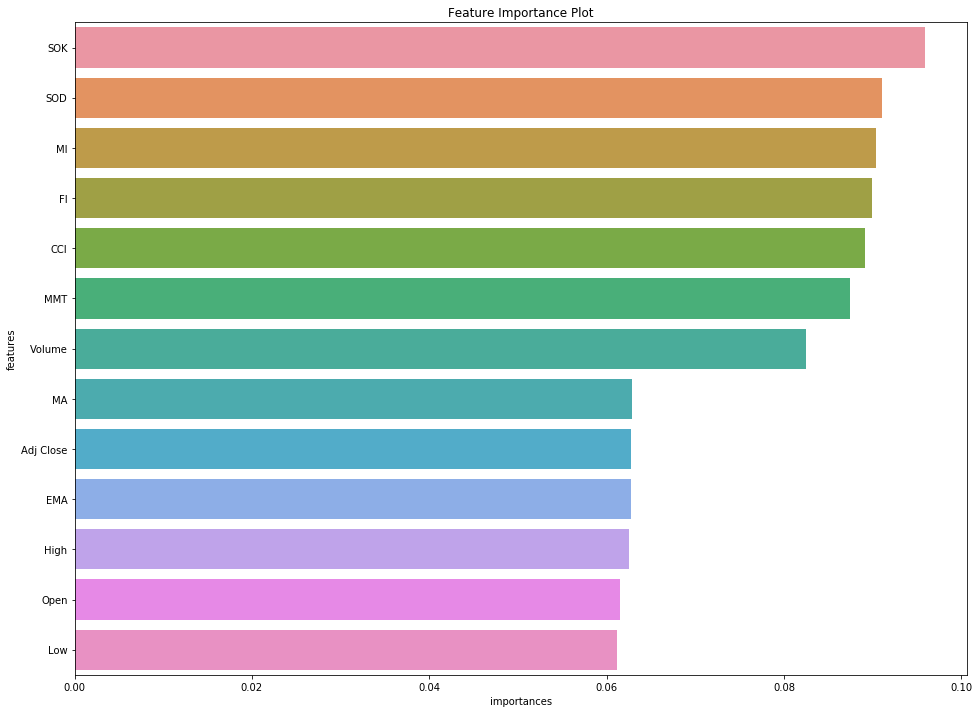

--------------------------------------------------------
	Performing optimization...
--------------------------------------------------------
Classifier: grid_RandomForestClassifier
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 3}
Best training accuracy: 0.5727109515260324
Test set accuracy score for best params: 0.47489539748953974
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_RandomForestClassifier_PCA
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 7}
Best training accuracy: 0.5789946140035906
Test set accuracy score for best params: 0.48535564853556484
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_KNN
Best params: {'clf__n_neighbors': 9}
Best training accuracy: 0.545780969479353

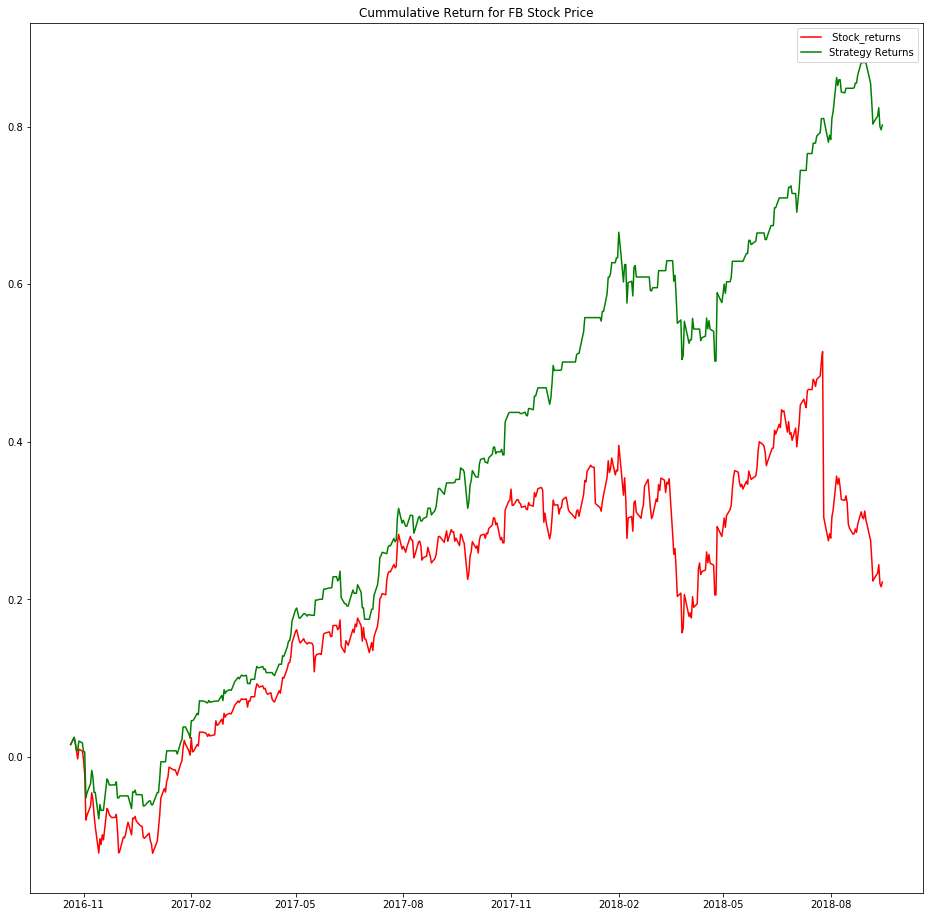

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep  4 22:58:31 2018

@author: kennedy
"""

from datetime import datetime
from PredictiveModel import Model
from . import FetchData, NormalizeData
from . import Predictors, feature_importance
import numpy as np
import matplotlib.pyplot as plt

if __name__ == '__main__':
    stock_name = ['TSLA', 'IBM', 'AAPL', 'MSFT', 'F', 'GM', 'GOLD', 'FB']
    for ii in stock_name:
        dataframe = FetchData(ii, "yahoo", datetime(2000, 1, 1), datetime.now()).fetch()
        pred = Predictors(dataframe)
        Xf, Yf, X_train, X_test, Y_train, Y_test = NormalizeData(dataframe, 7, 15).normalizeData()
        feature_importance(Xf, Yf)
        split = int(0.7*len(dataframe))
        GSCV = Model().optimize(X_train, X_test, Y_train, Y_test)
        dataframe['Predicted_Signal'] = GSCV.predict(Xf)
        dataframe['Stock_returns'] = np.log(dataframe['Close']/dataframe['Close'].shift(1))
        Cumulative_returns = np.cumsum(dataframe[split:]['Stock_returns'])
        dataframe['Startegy_returns'] = dataframe['Stock_returns']* dataframe['Predicted_Signal'].shift(1)
        Cumulative_Strategy_returns = np.cumsum(dataframe[split:]['Startegy_returns'])
        plt.figure(figsize=(16,16))
        plt.plot(Cumulative_returns, color='r',label = ' Stock_returns')
        plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
        plt.legend()
        plt.title('Cummulative Return for {} Stock Price'.format(ii))
        plt.savefig("D:\\GIT PROJECT\\STOCK-RETURN-PREDICTION-USING-KNN-SVM-GUASSIAN-PROCESS-ADABOOST-TREE-REGRESSION-AND-QDA\\_IMAGES\\Stock{}_2018.png".format(ii))
        plt.show()
        
    
    
